In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/futuresfirst/StockPrice.csv
/kaggle/input/futuresfirst/Data.csv


In [2]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Cell 2: Load Data
data_df = pd.read_csv('/kaggle/input/futuresfirst/Data.csv')
stock_df = pd.read_csv('/kaggle/input/futuresfirst/StockPrice.csv')

print("Data Shape:", data_df.shape)
print("Stock Shape:", stock_df.shape)

Data Shape: (3902, 2)
Stock Shape: (3839, 2)


In [4]:
# Cell 3: Preprocess and Merge
data_df['Date'] = pd.to_datetime(data_df['Date'])
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

data_df = data_df.sort_values('Date').reset_index(drop=True)
stock_df = stock_df.sort_values('Date').reset_index(drop=True)

df = pd.merge(data_df, stock_df, on='Date', how='inner')
print("Merged Shape:", df.shape)
df.head(10)

Merged Shape: (3802, 3)


,Date,Data,Price
0,2010-01-04,0.700,1178.00
1,2010-01-05,0.699,1181.50
2,2010-01-06,0.694,1182.25
3,2010-01-07,0.692,1186.75
4,2010-01-08,0.691,1190.75
5,2010-01-11,0.689,1191.75
6,2010-01-12,0.685,1183.25
7,2010-01-13,0.684,1190.75
8,2010-01-14,0.682,1194.50
9,2010-01-15,0.680,1181.50


In [5]:
# Cell 4: Feature Engineering
df['Data_Change'] = df['Data'].diff()
df['Data_Pct_Change'] = df['Data'].pct_change() * 100
df['Price_Change'] = df['Price'].diff()

for lag in range(1, 6):
    df[f'Data_Lag_{lag}'] = df['Data'].shift(lag)
    df[f'Data_Change_Lag_{lag}'] = df['Data_Change'].shift(lag)

for window in [3, 5, 7, 14]:
    df[f'Data_MA_{window}'] = df['Data'].rolling(window=window).mean()
    df[f'Price_MA_{window}'] = df['Price'].rolling(window=window).mean()

df['Data_Momentum_5'] = df['Data'] - df['Data'].shift(5)
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

df = df.dropna().reset_index(drop=True)
print("Shape after feature engineering:", df.shape)

Shape after feature engineering: (3789, 28)


In [6]:
# Cell 5: Prepare Features and Target
exclude_cols = ['Date', 'Price', 'Price_Change']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df['Price']

print("Features:", len(feature_cols))
print("Samples:", len(X))

Features: 25
Samples: 3789


In [7]:
# Cell 6: Train-Test Split
train_size = int(len(df) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
test_dates = df['Date'][train_size:]

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 3031
Test size: 758


In [8]:
# Cell 7: Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Cell 8: Train Model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

In [10]:
# Cell 9: Evaluate Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("=" * 40)
print("MODEL PERFORMANCE")
print("=" * 40)
print(f"R² Score:  {r2:.4f}")
print(f"RMSE:      {rmse:.4f}")
print(f"MAE:       {mae:.4f}")
print(f"MAPE:      {mape:.2f}%")

MODEL PERFORMANCE
R² Score:  0.9972
RMSE:      32.8893
MAE:       25.3181
MAPE:      0.53%


In [11]:
# Cell 10: Impact Analysis
slope, intercept, r_value, p_value, _ = stats.linregress(df['Data_Change'], df['Price_Change'])
correlation = df['Data_Change'].corr(df['Price_Change'])

print("=" * 40)
print("IMPACT ANALYSIS")
print("=" * 40)
print(f"Correlation: {correlation:.4f}")
print(f"Slope: {slope:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significant: {'Yes' if p_value < 0.05 else 'No'}")
print(f"\nInterpretation:")
print(f"1 unit Data increase → {slope:.2f} price change")

IMPACT ANALYSIS
Correlation: -0.0283
Slope: -73.7401
P-value: 0.0817
Significant: No

Interpretation:
1 unit Data increase → -73.74 price change


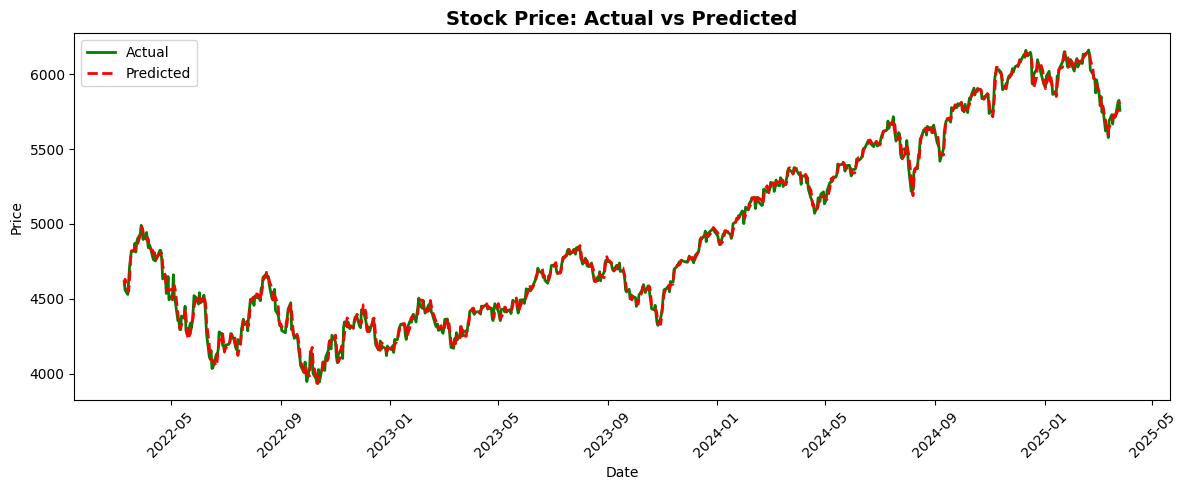

In [12]:
# Cell 11: Visualization - Actual vs Predicted
plt.figure(figsize=(12, 5))
plt.plot(test_dates, y_test.values, label='Actual', color='green', linewidth=2)
plt.plot(test_dates, y_pred, label='Predicted', color='red', linestyle='--', linewidth=2)
plt.title('Stock Price: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300)
plt.show()

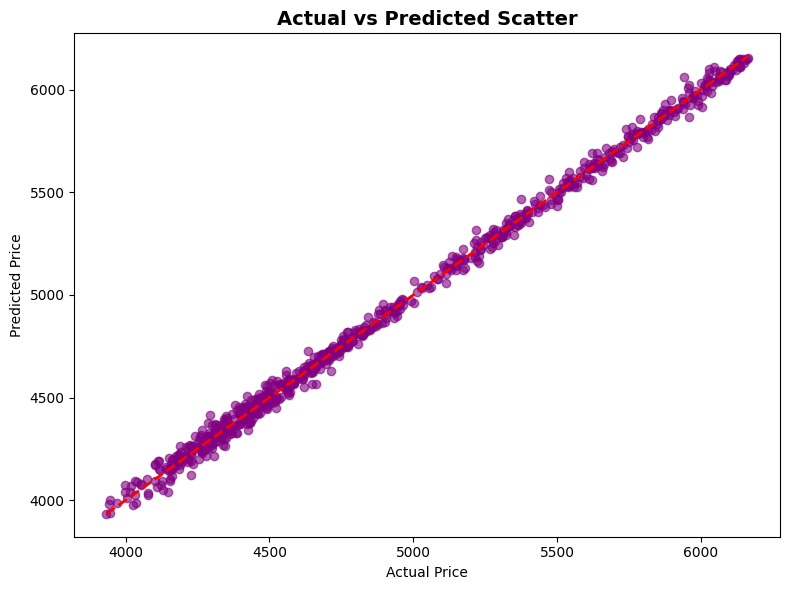

In [13]:
# Cell 12: Visualization - Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title('Actual vs Predicted Scatter', fontsize=14, fontweight='bold')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.tight_layout()
plt.savefig('scatter_plot.png', dpi=300)
plt.show()

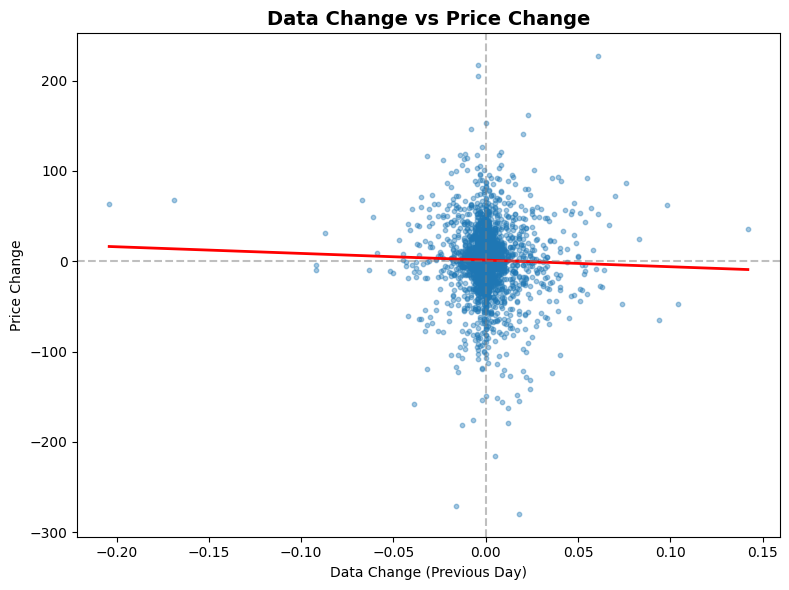

In [14]:
# Cell 13: Visualization - Impact Analysis
plt.figure(figsize=(8, 6))
plt.scatter(df['Data_Change'], df['Price_Change'], alpha=0.4, s=10)
x_line = np.linspace(df['Data_Change'].min(), df['Data_Change'].max(), 100)
plt.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.title('Data Change vs Price Change', fontsize=14, fontweight='bold')
plt.xlabel('Data Change (Previous Day)')
plt.ylabel('Price Change')
plt.tight_layout()
plt.savefig('impact_analysis.png', dpi=300)
plt.show()

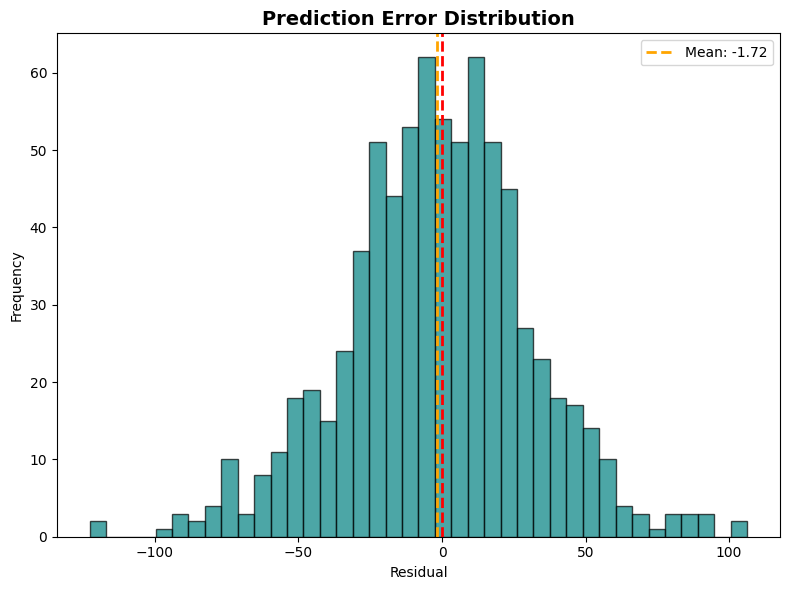

In [15]:
# Cell 14: Visualization - Residuals
residuals = y_test.values - y_pred

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=40, color='teal', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.axvline(x=np.mean(residuals), color='orange', linestyle='--', linewidth=2, label=f'Mean: {np.mean(residuals):.2f}')
plt.title('Prediction Error Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('residuals.png', dpi=300)
plt.show()

In [16]:
# Cell 15: Save Results
predictions_df = pd.DataFrame({
    'Date': test_dates.values,
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Error': residuals
})
predictions_df.to_csv('predictions.csv', index=False)

print("Saved: predictions.csv")
predictions_df.head(10)

Saved: predictions.csv


,Date,Actual,Predicted,Error
0,2022-03-10,4614.00,4588.409193,25.590807
1,2022-03-11,4558.25,4629.831770,-71.581770
2,2022-03-14,4528.75,4562.296012,-33.546012
3,2022-03-15,4618.75,4549.364770,69.385230
4,2022-03-16,4714.75,4627.628830,87.121170
5,2022-03-17,4767.25,4747.907765,19.342235
6,2022-03-18,4818.75,4818.978361,-0.228361
7,2022-03-21,4817.50,4824.559307,-7.059307
8,2022-03-22,4870.25,4849.554119,20.695881
9,2022-03-23,4812.75,4833.488629,-20.738629


In [17]:
# Cell 16: Final Summary
print("=" * 50)
print("FINAL SUMMARY")
print("=" * 50)
print(f"Model: Linear Regression")
print(f"R² Score: {r2:.4f} ({r2*100:.2f}% variance explained)")
print(f"MAPE: {mape:.2f}%")
print(f"Data-Price Correlation: {correlation:.4f} (Weak)")
print(f"Statistical Significance: {'Yes' if p_value < 0.05 else 'No'}")
print("=" * 50)

FINAL SUMMARY
Model: Linear Regression
R² Score: 0.9972 (99.72% variance explained)
MAPE: 0.53%
Data-Price Correlation: -0.0283 (Weak)
Statistical Significance: No
